In [1]:
import numpy as np
import matplotlib as plt
import h5py
import scipy
from sklearn.metrics import f1_score   
from sklearn.metrics import accuracy_score
from scipy import special
from matplotlib.pyplot import imshow
import cv2
import os
import re
import time
import keras
import gc
from keras.datasets import mnist
from keras import backend as k
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:

class AdaBound_N():


    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))

        self.defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        
        self.param_groups = []

        self.param_groups.append(dict(params=params, lr=lr, betas=betas, final_lr=final_lr, 
                                      gamma=gamma, eps=eps, weight_decay=weight_decay, amsbound=amsbound))

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))


    def initialize_state(self, parameters):

        L = len(parameters) # number of layers in the neural networks
        self.m = {}
        self.v = {}

        for l in range(L):

            

            self.m["dW" + str(l + 1)] = np.zeros_like(parameters[l].weight)
            self.m["db" + str(l + 1)] = np.zeros_like(parameters[l].bias)

            self.v["dW" + str(l+1)] = np.zeros_like(parameters[l].weight)
            self.v["db" + str(l+1)] = np.zeros_like(parameters[l].bias)
    


    
    def step(self, state=1):

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p, l in zip(group['params'], range(len(group['params']))):
                if p.grads is None:
                    continue
                grad = p.grads
                
                # State initialization
                beta1, beta2 = group['betas']
                if state == 1:
                  self.initialize_state(self.param_groups[0]['params'])
                # Decay the first and second moment running average coefficient
                self.m["dW" + str(l + 1)] = beta1 * self.m["dW" + str(l + 1)] + (1 - beta1) * grad['dW']
                self.m["db" + str(l + 1)] = beta1 * self.m["db" + str(l + 1)] + (1 - beta1) * grad['db']

                self.v["dW" + str(l + 1)] = beta2 * self.v["dW" + str(l + 1)] + (1 - beta2) * np.power(grad['dW'], 2)
                self.v["db" + str(l + 1)] = beta2 * self.v["db" + str(l + 1)] + (1 - beta2) * np.power(grad['db'], 2)

                
                denom_W = np.sqrt(self.v["dW" + str(l + 1)]) + group['eps']
                denom_b = np.sqrt(self.v["db" + str(l + 1)]) + group['eps']

                bias_correction1 = 1 - beta1 ** state
                bias_correction2 = 1 - beta2 ** state
                step_size = group['lr'] * np.sqrt(bias_correction2)/ bias_correction1

                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state))

                step_size_W = np.full_like(denom_W, step_size)
                step_size_b = np.full_like(denom_b, step_size)

                step_size_W = np.clip(step_size_W / denom_W, lower_bound, upper_bound) * self.m["dW" + str(l + 1)] 
                step_size_b = np.clip(step_size_b / denom_b, lower_bound, upper_bound) * self.m["db" + str(l + 1)]

#               update parameters
                p.weight -= step_size_W
                p.bias -= step_size_b

                

    


In [3]:
class Ada():


    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        self.defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        
        self.param_groups = []

        self.param_groups.append(dict(params=params, lr=lr, betas=betas,eps=eps, weight_decay=weight_decay, amsbound=amsbound))

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))


    def initialize_state(self, parameters):

        L = len(parameters) # number of layers in the neural networks
        self.v = {}
        self.s = {}

        for l in range(L):

            

            self.v["dW" + str(l + 1)] = np.zeros_like(parameters[l].weight)
            self.v["db" + str(l + 1)] = np.zeros_like(parameters[l].bias)

            self.s["dW" + str(l+1)] = np.zeros_like(parameters[l].weight)
            self.s["db" + str(l+1)] = np.zeros_like(parameters[l].bias)

    
    def step(self, state=0):
        v_corrected = {}                         # Initializing first moment estimate, python dictionary
        s_corrected = {}

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p, l in zip(group['params'], range(len(group['params']))):
                if p.grads is None:
                    continue
                grad = p.grads
                
                # State initialization
                beta1, beta2 = group['betas']
                if state == 0:
                  self.initialize_state(self.param_groups[0]['params'])
                # Decay the first and second moment running average coefficient
                self.v["dW" + str(l + 1)] = beta1 * self.v["dW" + str(l + 1)] + (1 - beta1) * grad['dW']
                self.v["db" + str(l + 1)] = beta1 * self.v["db" + str(l + 1)] + (1 - beta1) * grad['db']

                v_corrected["dW" + str(l + 1)] = self.v["dW" + str(l + 1)] / (1 - np.power(beta1, state+1)+ group['eps'])
                v_corrected["db" + str(l + 1)] = self.v["db" + str(l + 1)] / (1 - np.power(beta1, state+1)+ group['eps'])

                self.s["dW" + str(l + 1)] = beta2 * self.s["dW" + str(l + 1)] + (1 - beta2) * np.power(grad['dW'], 2)
                self.s["db" + str(l + 1)] = beta2 * self.s["db" + str(l + 1)] + (1 - beta2) * np.power(grad['db'], 2)

                s_corrected["dW" + str(l + 1)] = self.s["dW" + str(l + 1)] / (1 - np.power(beta2, state+1) + group['eps'])
                s_corrected["db" + str(l + 1)] = self.s["db" + str(l + 1)] / (1 - np.power(beta2, state+1) + group['eps'])

#               update parameters
                p.weight = p.weight - group['lr'] * v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + group['eps'])
                p.bias = p.bias - group['lr'] * v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + group['eps'])


In [4]:

def relu(x):
  return np.maximum(0, x)

In [5]:

def reluDerivative(x):
  
    x = (x > 0) * 1
    return x

In [6]:

def zero_pad(X, pad):

  X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0,0)), mode="constant", constant_values=(0, 0))

  return X_pad

In [7]:

class Linear():   

  def __init__(self, in_n, out_n, activation='relu'):

    self.in_n = in_n
    self.out_n = out_n
    self.activation = activation
    self.eps = 0.00000001
    self.initialize_parameters_deep([in_n, out_n])

  def initialize_parameters_deep(self, layer_dims):
  
    
    L = len(layer_dims)

    for l in range(1, L):
      self.weight = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
      self.bias = np.zeros((layer_dims[l], 1))


  def linear_forward(self, A, W, b):

    Z = np.dot(W, A) + b
    cache = A, W, b

    return Z, cache

  def linear_activation_forward(self, A_prev, W, b, activation):

    if activation == "relu":
      Z, linear_cache = self.linear_forward(A_prev, W, b)
      A, activation_cache = self.relu(Z)

    if activation == "sigmoid":
      Z, linear_cache = self.linear_forward(A_prev, W, b)
      A, activation_cache = self.sigmoid(Z)

    if activation =='softmax':
      Z, linear_cache = self.linear_forward(A_prev, W, b)
      A, activation_cache = self.softmax(Z)

    cache = (linear_cache, activation_cache)
    return A, cache

  def L_linear_forward(self, X):

    A = X
    self.caches = []
    
    

    AL, cache = self.linear_activation_forward(A, self.weight, self.bias, activation=self.activation)
    self.caches.append(cache)

    return AL

  def compute_cost(self, AL, Y):
    
    AL = (AL==0) * self.eps + AL
    Y = Y.reshape(AL.shape)
    loss=-np.sum(Y*np.log(AL))
    self.dAL = AL - Y

    return loss/float(AL.shape[1])
    

  def linear_backward(self, dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis = 1, keepdims =True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

  def linear_activation_backward(self, dA, cache, activation):

    linear_cache, activation_cache = cache

    if self.activation == "relu":
      dZ = self.relu_backward(dA, activation_cache)
      dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

    if self.activation == "sigmoid":
      dZ = self.sigmoid_backward(dA, activation_cache)
      dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

    if self.activation == "softmax":
      dZ = dA
      dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

  def Backward(self, dA_prev=0.5):

    grads = {}
    L = len(self.caches) 
    if self.activation == 'softmax':
      dAL = self.dAL
    else:
      dAL = dA_prev

    current_cache = self.linear_activation_backward(dAL, self.caches[L-1], activation=self.activation)
    d_Aprev_temp, dW_temp, db_temp = current_cache
    grads["dA_prev"] = d_Aprev_temp
    grads["dW"] = dW_temp
    grads["db"] = db_temp

    for l in reversed(range(L - 1)):
      print('lol')
      current_cache = self.linear_activation_backward(grads["dA" + str(l + 1)], self.caches[l], activation="relu")
      d_Aprev_temp, dW_temp, db_temp = current_cache
      grads["dA" + str(l)] = d_Aprev_temp
      grads["dW" + str(l + 1)] = dW_temp
      grads["db" + str(l + 1)] = db_temp

    self.grads = grads
    return grads

  def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2 

    for l in range(L):
          
      parameters["W"+str(l+1)] -= learning_rate * grads["dW"+str(l+1)] 
      parameters["b"+str(l+1)] -= learning_rate * grads["db"+str(l+1)] 
          
          
    return parameters

  def softmax(self, Z):

    A = special.softmax(Z)

    return A, Z

  def sigmoid(self, Z):

    A = 1/(1+np.exp(-Z))

    return A, Z

  def sigmoid_backward(self, dA, Z):

    g = self.sigmoid(Z)[0] * (1 - self.sigmoid(Z)[0])
    dZ = np.multiply(g, dA)

    return dZ

  def relu(self, Z):

    A = Z * (Z > 0)

    return A, Z

  def relu_backward(self, dA, Z):

    g = 1 * (Z > 0)
    dZ = np.multiply(g, dA)

    return dZ

In [8]:
def getWindows(input, output_size, kernel_size, padding=1, stride=1, dilate=0):
    working_input = input
    working_pad = padding

    # pad the input if necessary
    if working_pad != 0:
        working_input = zero_pad(working_input, padding)

    if dilate != 0:
        working_input = np.insert(working_input, range(1, input.shape[1]), 0.5, axis=1)
        working_input = np.insert(working_input, range(1, input.shape[2]), -0.5, axis=2)

    b, out_h, out_w, in_c = output_size
    b, _, _, out_c = input.shape
    batch_str, kern_h_str, kern_w_str, channel_str = working_input.strides

    return np.lib.stride_tricks.as_strided(
        working_input,
        (b, out_h, out_w, out_c, kernel_size, kernel_size),
        (batch_str, stride * kern_h_str, stride * kern_w_str, channel_str, kern_h_str, kern_w_str)
    )

In [9]:

class Conv2D:
    """
    An implementation of the convolutional layer. We convolve the input with out_channels different filters
    and each filter spans all channels in the input.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, pooling=False):
        """
        :param in_channels: the number of channels of the input data
        :param out_channels: the number of channels of the output(aka the number of filters applied in the layer)
        :param kernel_size: the specified size of the kernel(both height and width)
        :param stride: the stride of convolution
        :param padding: the size of padding. Pad zeros to the input with padding size.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.pooling = pooling

        self.cache = None

        self._init_weights()

    def _init_weights(self):
        self.weight = 7.5e-3 * np.random.randn(self.kernel_size, self.kernel_size, self.in_channels, self.out_channels)
        self.bias = np.zeros((1, 1, 1, self.out_channels))

    def conv_forward(self, x, activation='relu'):


        A_prev = x
        m, n_H_prev, n_W_prev, n_C_prev = x.shape
        W = self.weight
        b = self.bias
        f, f, n_C_prev, n_C = W.shape

        stride = self.stride
        pad = self.padding

        n_H = int((n_H_prev + 2*pad - f)/stride) + 1
        n_W = int((n_W_prev + 2*pad - f)/stride) + 1

        if self.pooling:
          n_H = int(n_H/2)
          n_W = int(n_W/2)

        max, min = np.amax(x), np.amin(x)
        

        windows = getWindows(x, (m, n_H, n_W, n_C), self.kernel_size, self.padding, self.stride, dilate=0)
        self.windows = windows
        #windows = np.nan_to_num(windows, nan = max)
       # windows = np.clip(windows, min, max)
        
        out = np.einsum('bhwikl,klio->bhwo', windows, self.weight)
# Check out on nan valye   

#        if True in np.isnan(out):
#          out = np.nan_to_num(out, nan = max)
#          out = np.clip(out, np.amin(out), max)

        self.out_prev = out

        # add bias to kernels
        out += self.bias
        self.cache_activation = out

        out = relu(out)
        self.out_later = out
        # Making sure your output shape is correct
        assert(out.shape == (m, n_H, n_W, n_C))

        self.cache = (A_prev, windows)
        



        return out

    def Backward(self, dout):

        m = dout.shape[0]
        stride = self.stride
        padding = self.padding
        W = self.weight
        b = self.bias

        max, min = np.amax(dout), np.amin(dout)
        self.dout_pred = dout

        dout = reluDerivative(self.cache_activation) * dout
       # self.dout_after = dout
        
        (A_prev, windows) = self.cache

        dout_windows = getWindows(dout, A_prev.shape, self.kernel_size, padding=padding, stride=1, dilate=0)

 #       Check dout_windows on nan value
 #       if True in np.isnan(dout_windows):
 #         dout_windows = np.nan_to_num(dout_windows, nan = max)
 #         dout_windows = np.clip(dout_windows, min, max)

        self.dout_windows = dout_windows
        rot_kern = np.rot90(self.weight, 2, axes=(2, 3))
       # self.rot_kern = rot_kern

        db = np.sum(dout, axis=(0, 1, 2))
        dW = np.einsum('bhwikl,bhwo->klio', windows, dout)
        dA_prev = np.einsum('bhwokl,klio->bhwi', dout_windows, self.weight) 
        
 #      Check dA_prev on exploding gradient
 #       if np.sum(dA_prev) >2 or np.sum(dA_prev)< -2: 
 #         dA_prev = np.clip(dA_prev, min, max)         
        
        dW /= m 
        db /= m

        grads = dict(dA_prev=dA_prev, dW=dW, db=db)
        self.grads = grads
        return grads


In [10]:

class VGG16_V():
    def __init__(self, num_classes=10, shrink=7, batch_size=1):

        self.layer1 = Conv2D(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.layer2 = Conv2D(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer3 = Conv2D(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.layer4 = Conv2D(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer5 = Conv2D(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.layer6 = Conv2D(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.layer7 = Conv2D(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer8 = Conv2D(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer9 = Conv2D(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer10 = Conv2D(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer11 = Conv2D(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer12 = Conv2D(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer13 = Conv2D(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, pooling=True)
        self.Lnn1 = Linear(shrink*shrink*512, 4096)
        self.Lnn2 = Linear(4096, 4096)
        self.Lnn3 = Linear(4096, num_classes, activation='softmax')

        
    def forward(self, x, batch_size=1):
        out = self.layer1.conv_forward(x)
        out = self.layer2.conv_forward(out)
        #print(out.shape)
        out = self.layer3.conv_forward(out)
        out = self.layer4.conv_forward(out)
        #print(out.shape)
        out = self.layer5.conv_forward(out)
        out = self.layer6.conv_forward(out)
        out = self.layer7.conv_forward(out)
        #print(out.shape)
        out = self.layer8.conv_forward(out)
        out = self.layer9.conv_forward(out)
        out = self.layer10.conv_forward(out)
        #print(out.shape)
        out = self.layer11.conv_forward(out)
        out = self.layer12.conv_forward(out)
        out = self.layer13.conv_forward(out)
        #print(out.shape)
        out = out.reshape(-1, batch_size)
        #print(out.shape)
        out = self.Lnn1.L_linear_forward(out)
        out = self.Lnn2.L_linear_forward(out)
        out = self.Lnn3.L_linear_forward(out)

        return out

    def backward(self, Layers, batch_size=1):

      self.GR = []
      grads = self.Lnn3.Backward()
      self.GR.append(grads)

      for l in Layers[0:2]: 
        grads = l.Backward(grads['dA_prev'])
        self.GR.append(grads)
      A_prev = self.layer13.cache[0]
      dim = int(A_prev.shape[1] / 2)
      grads['dA_prev'] = grads['dA_prev'].reshape(batch_size, dim, dim, 512)
      for l in Layers[2:]: 
        grads = l.Backward(grads['dA_prev'])
        self.GR.append(grads)

      GR = self.GR

      return GR


In [11]:
# Recieve Layers from model
def sp_prop_V(Model):

  spisok = []
  spisok_l = []

  for l in Model.__dict__.keys():
    spisok.append(Model.__dict__[l])

  for l in reversed(spisok):
    spisok_l.append(l)
    
#  del spisok_l[0]
  
  return spisok_l

In [12]:
import gc
for i in range(10):
  gc.collect()

In [13]:
import tensorflow as tf
from matplotlib import pyplot
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


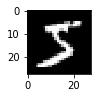

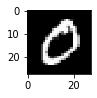

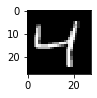

In [14]:
for i in range(3):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [15]:
# expand new axis, channel axis 
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)
# it's always better to normalize 
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
# resize the input shape , i.e. old shape: 28, new shape: 32
x_train, x_test = tf.image.resize(x_train, [32,32]), tf.image.resize(x_test, [32,32]) # if we want to resize 
# one-hot 
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [16]:
x_train.shape

TensorShape([60000, 32, 32, 1])

In [17]:
print(x_train.shape, y_train.shape)

(60000, 32, 32, 1) (60000, 10)


In [22]:
# Batch_size
X_train, Y_train, X_val, Y_val = [], [], [], []
batch_size = 3
for i in range(0, 60, batch_size):
  start_idx, end_idx = i, i + batch_size
  X_train.append(x_train[start_idx:end_idx])
  Y_train.append(y_train[start_idx:end_idx].reshape(10, batch_size))

for i in range(0, 10, batch_size):
  start_idx, end_idx = i, i + batch_size
  X_val.append(x_test[start_idx:end_idx])
  Y_val.append(y_test[start_idx:end_idx].reshape(10, batch_size))

In [23]:
X_val[0].shape

TensorShape([3, 32, 32, 1])

In [26]:
x = X_val[0]

shrink = x.shape[1]//32
batch_size = x.shape[0]
print('shrink = ', shrink, 'batch_size = ', batch_size)

model = VGG16_V(num_classes=10, shrink=shrink)
params = sp_prop_V(model)
#print(params)
params.reverse()
opt = AdaBound_N(params, lr=1e-3, betas=(0.9, 0.999), final_lr=7.5e-3, gamma=1e-5,
                 eps=1e-8, weight_decay=0, amsbound=False)

y = Y_val[2]
print(y.reshape(y.shape[1], y.shape[0]))

running_loss = 0
Layers = sp_prop_V(model)
num_epoch = 10

for i in range(1, num_epoch + 1):

  y_true, y_preds, TR, PR = [], [], [], []
  running_loss = 0
  opt.initialize_state(params)

  for x, y in zip(X_val[2:3], Y_val[2:3]):

    out = model.forward(x, batch_size)
    loss = model.Lnn3.compute_cost(out, y)
    running_loss += loss
    grads = model.backward(Layers[1:], batch_size)
    opt.step(i)

    out, y = out.reshape(out.shape[1], out.shape[0]), y.reshape(y.shape[1], y.shape[0])
    print(out)
    y_preds.extend(out)
    y_true.extend(y)

    PR.extend(np.argmax(out, axis=1))
    TR.extend(np.argmax(y, axis=1))

  
  
  y_true = np.array(y_true, dtype=np.int16)
  y_preds = np.array(y_preds, dtype=np.int16)

  print('loss = ', running_loss)
  print('f1_macro = ', f1_score(TR, PR, average='macro'))
  print('accuracy = ', accuracy_score(TR, PR))

shrink =  1 batch_size =  3
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333]
 [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333]
 [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333]]
loss =  3.4011973816621595
f1_macro =  0.16666666666666666
accuracy =  0.3333333333333333
[[0.0332149  0.03321411 0.03321504 0.03354191 0.03354694 0.0335434
  0.03324828 0.03324787 0.03324689 0.0332295 ]
 [0.0332327  0.03323057 0.03325035 0.03325054 0.03325019 0.03325457
  0.03325434 0.03325334 0.03355481 0.03355698]
 [0.03355508 0.03326721 0.03326664 0.03326812 0.03351235 0.03351505
  0.03351294 0.03325434 0.0332563  0.03325476]]
loss =  3.3950269023941506
f1_macro =  0.5
accuracy =  0.6666666666666666
[[0.03301582 0.03

KeyboardInterrupt: ignored